### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Бармина Ольга Константиновна
##### Группа:   НФИбд-01-19

## Москва 2022
***

### Вариант №18

1. При помощи модуля `pandas_datareader` считайте котировки указанной в индивидуальным задании акции за указанный период времени. 

2. Визуализируйте котировки акции (столбец `Adj Close`) за весь период на графике. Подпишите оси и рисунок.

3. Вычислите и визуализируйте заданный показатель акции в соответствии с индивидуальным заданием.

4.	Сформируйте обучающую, тестовую и валидационные выборки для обучения нейронной сети в соответствии с индивидуальным заданием. 

5.	Постройте нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

6.	Примените указанную в индивидуальном задании технику решения проблемы исчезающих градиентов и постройте нейронную сеть MLP с нормализующим слоем и тремя плотными скрытыми слоями из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества для тестовой выборки.

7.	Постройте рекуррентную нейронную сеть с нормализующим слоем и одним скрытым слоем LSTM из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

8.	Визуализируйте кривые обучения для трех построенных моделей на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительную ошибку (ошибку обучения, деленную на начальную ошибку на первой эпохе). 

9.	 Визуализируйте весь набор данных и прогнозы трех построенных моделей для обучающей и тестовой выборок на одном рисунке (ось X – даты, ось Y – стоимость акции), подписывая оси и рисунок и создавая легенду. 

С индивидуальными параметрами:

1. Считайте котировки акции с указанным ниже тикером за 2018-2019 год: GM     General Motors Company 
2. Показатель акции: дневная доходность, способ визуализации – диаграмма размаха  
3. Прогнозирование стоимости акции через 10 дней по данным за предыдущие 40 дней. 
4. Показатель качества RMSE 
5. Техника борьбы с исчезающими градиентами: Пакетная нормализацмя 

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os

In [ ]:
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yfin
# считаем данные об акциях
yfin.pdr_override()

aapl = pdr.get_data_yahoo('GM', 
                          start=dt.datetime(2018, 1, 1), 
                          end=dt.datetime(2019, 12, 31))
aapl.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,41.240002,41.869999,41.150002,41.799999,38.072212,6934600
2018-01-03,42.209999,42.950001,42.200001,42.820000,39.001247,14591600
2018-01-04,43.090000,44.250000,43.009998,44.139999,40.203522,17298700
2018-01-05,44.500000,44.639999,43.959999,44.009998,40.085125,9643300
2018-01-08,44.040001,44.590000,43.520000,44.220001,40.276398,13099600


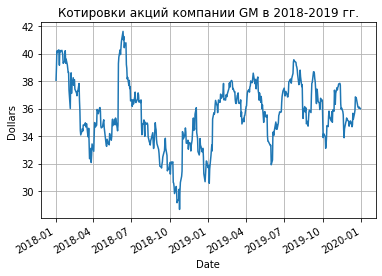

In [ ]:
# визуализируем данные
aapl['Adj Close'].plot.line(grid=True,title='Котировки акций компании GM в 2018-2019 гг.', ylabel='Dollars');

In [ ]:
# вычислим дневную доходность
d_close = aapl[['Adj Close']]
d_pct_ch = d_close.pct_change()
d_pct_ch2 = d_close / d_close.shift(1) - 1
d_pct_ch2.describe()

,Adj Close
count,501.000000
mean,0.000047
std,0.017937
min,-0.050195
25%,-0.008526
50%,0.000764
75%,0.009202
max,0.128734


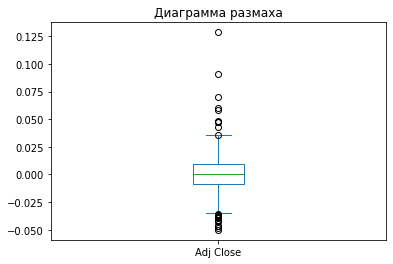

In [ ]:
# визуализируем ее диаграммой размаха
d_pct_ch2.plot.box(title='Диаграмма размаха');

In [ ]:
raw_data = aapl
adj = aapl['Adj Close']

In [ ]:
# подсчитаем размер тренировочной, тестовой и валидационной выборки
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
mean.shape, std.shape

((6,), (6,))

In [ ]:
raw_data.shape

(502, 6)

In [ ]:
# сформируем выборки
sampling_rate = 1
sequence_length = 40
delay = sampling_rate * (sequence_length + 10 - 1)
batch_size = 16

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset: # shapes in first data batch
    print("Форма признаков:", samples.shape)
    print("Форма откликов:", targets.shape)
    break

Форма признаков: (16, 40, 6)
Форма откликов: (16,)


In [ ]:
# построим и обучим нейронную сеть MLP с одним плотныс слоем
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, input_shape=(sequence_length, raw_data.shape[-1]), activation='relu', name='HiddenLayer'),  
  tf.keras.layers.Dense(1, name='OutputLayer')])

model.compile(optimizer="Adam", loss="mse", metrics=["mse"])
history1 = model.fit(train_dataset,
                    epochs=200,
                    validation_data=val_dataset)

Epoch 1/200
14/14 [==============================] - 2s 61ms/step - loss: 1224.3783 - mse: 1224.3782 - val_loss: 1333.3973 - val_mse: 1333.3972
Epoch 2/200
14/14 [==============================] - 0s 28ms/step - loss: 1211.7855 - mse: 1211.7855 - val_loss: 1326.3201 - val_mse: 1326.3201
Epoch 3/200
14/14 [==============================] - 0s 17ms/step - loss: 1200.3077 - mse: 1200.3077 - val_loss: 1320.0051 - val_mse: 1320.0052
Epoch 4/200
14/14 [==============================] - 0s 15ms/step - loss: 1189.7784 - mse: 1189.7786 - val_loss: 1314.1703 - val_mse: 1314.1703
Epoch 5/200
14/14 [==============================] - 0s 15ms/step - loss: 1180.3438 - mse: 1180.3436 - val_loss: 1308.8094 - val_mse: 1308.8094
Epoch 6/200
14/14 [==============================] - 0s 20ms/step - loss: 1171.3146 - mse: 1171.3147 - val_loss: 1303.8927 - val_mse: 1303.8927
Epoch 7/200
14/14 [==============================] - 0s 18ms/step - loss: 1162.7734 - mse: 1162.7732 - val_loss: 1299.6431 - val_mse: 12

In [ ]:
# оценим качество обучения показателем rmse
import math 
print(f"RMSE на тестовом наборе: {math.sqrt(model.evaluate(test_dataset)[1]):.2f}")

3/3 [==============================] - 0s 4ms/step - loss: 16.2753 - mse: 16.2753
RMSE на тестовом наборе: 4.03


In [ ]:
# применим батч-нормализацию и построим сеть с тремя плотными слоями
model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(16, input_shape=(sequence_length, raw_data.shape[-1]), activation='relu', name='HiddenLayer1'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(16, input_shape=(sequence_length, raw_data.shape[-1]), activation='relu', name='HiddenLayer2'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(16, input_shape=(sequence_length, raw_data.shape[-1]), activation='relu', name='HiddenLayer3'),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, name='OutputLayer2')])

model2.compile(optimizer="Adam", loss="mse", metrics=["mse"])
history2 = model2.fit(train_dataset,
                    epochs=200,
                    validation_data=val_dataset)

Epoch 1/200
14/14 [==============================] - 2s 29ms/step - loss: 1179.4668 - mse: 1179.4668 - val_loss: 1306.9761 - val_mse: 1306.9761
Epoch 2/200
14/14 [==============================] - 0s 10ms/step - loss: 1174.4073 - mse: 1174.4072 - val_loss: 1298.5348 - val_mse: 1298.5348
Epoch 3/200
14/14 [==============================] - 0s 12ms/step - loss: 1168.9482 - mse: 1168.9482 - val_loss: 1289.7985 - val_mse: 1289.7985
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 1162.7412 - mse: 1162.7413 - val_loss: 1280.5750 - val_mse: 1280.5748
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 1155.6766 - mse: 1155.6765 - val_loss: 1270.7676 - val_mse: 1270.7676
Epoch 6/200
14/14 [==============================] - 0s 10ms/step - loss: 1147.6923 - mse: 1147.6921 - val_loss: 1261.0012 - val_mse: 1261.0010
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - loss: 1138.7744 - mse: 1138.7742 - val_loss: 1250.4828 - val_mse: 12

In [ ]:
# оценим качество новой модели
print(f"RMSE на тестовом наборе: {math.sqrt(model2.evaluate(test_dataset)[1]):.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 4.2328 - mse: 4.2328
RMSE на тестовом наборе: 2.06


In [ ]:
# создадим рекуррентную сеть
model_rnn = tf.keras.Sequential([
  tf.keras.layers.LSTM(16, input_shape=(sequence_length, raw_data.shape[-1]), name='HiddenLayer4'),  
  tf.keras.layers.Dense(1, name='OutputLayer4')])

model_rnn.compile(loss='mean_squared_error', optimizer='adam')
history3 = model_rnn.fit(train_dataset, epochs=200, batch_size=16, verbose=2)

Epoch 1/200
14/14 - 2s - loss: 1178.4075 - 2s/epoch - 156ms/step
Epoch 2/200
14/14 - 0s - loss: 1157.7491 - 242ms/epoch - 17ms/step
Epoch 3/200
14/14 - 0s - loss: 1131.8948 - 239ms/epoch - 17ms/step
Epoch 4/200
14/14 - 0s - loss: 1094.9863 - 244ms/epoch - 17ms/step
Epoch 5/200
14/14 - 0s - loss: 1037.4707 - 236ms/epoch - 17ms/step
Epoch 6/200
14/14 - 0s - loss: 973.5585 - 246ms/epoch - 18ms/step
Epoch 7/200
14/14 - 0s - loss: 922.2969 - 231ms/epoch - 16ms/step
Epoch 8/200
14/14 - 0s - loss: 873.8742 - 243ms/epoch - 17ms/step
Epoch 9/200
14/14 - 0s - loss: 825.8577 - 234ms/epoch - 17ms/step
Epoch 10/200
14/14 - 0s - loss: 782.6398 - 244ms/epoch - 17ms/step
Epoch 11/200
14/14 - 0s - loss: 745.7211 - 242ms/epoch - 17ms/step
Epoch 12/200
14/14 - 0s - loss: 713.7962 - 236ms/epoch - 17ms/step
Epoch 13/200
14/14 - 0s - loss: 686.2636 - 245ms/epoch - 17ms/step
Epoch 14/200
14/14 - 0s - loss: 662.0920 - 239ms/epoch - 17ms/step
Epoch 15/200
14/14 - 0s - loss: 640.7060 - 253ms/epoch - 18ms/step
E

In [ ]:
# оценим качество обучения
print(f"RMSE на тестовом наборе: {math.sqrt(model_rnn.evaluate(test_dataset)):.2f}")

3/3 [==============================] - 1s 7ms/step - loss: 7.0836
RMSE на тестовом наборе: 2.66


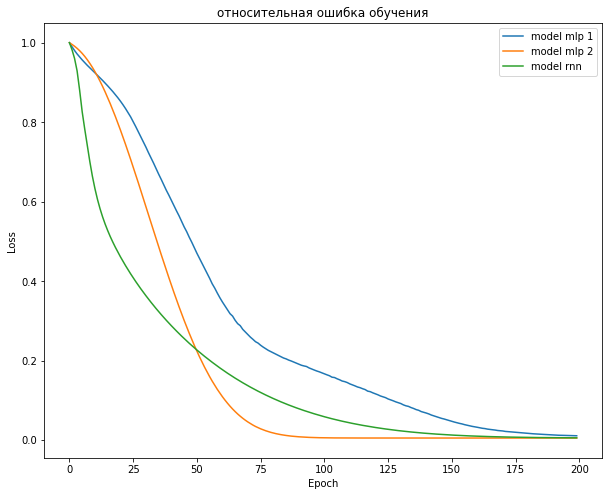

In [ ]:
# визуализируем кривые обучения, используя относительную ошибку
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot([i/history1.history['loss'][0] for i in history1.history['loss']], label='model mlp 1')
ax.plot([i/history2.history['loss'][0] for i in history2.history['loss']], label='model mlp 2')
ax.plot([i/history3.history['loss'][0] for i in history3.history['loss']], label='model rnn')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('относительная ошибка обучения')
ax.legend()

























In [ ]:
# сместим данные предсказаний обучающей и тренировочной выборки
prediction1 = model.predict(train_dataset)
prediction1_2 = model.predict(test_dataset)
prediction2 = model2.predict(train_dataset)
prediction2_2 = model2.predict(test_dataset)
prediction3 = model_rnn.predict(train_dataset)
prediction3_2 = model_rnn.predict(test_dataset)
look_back=40

trainPredictPlot1 = np.empty_like(adj)
trainPredictPlot1[:] = np.nan
trainPredictPlot1[look_back:len(prediction1)+look_back] = np.resize(prediction1, (len(prediction1)))

testPredictPlot1 = np.empty_like(adj)
testPredictPlot1[:] = np.nan
testPredictPlot1[num_train_samples + num_val_samples - 1 + look_back + 10:len(adj) - look_back] = np.resize(prediction1_2, (len(prediction1_2) - 1))
    
trainPredictPlot2 = np.empty_like(adj)
trainPredictPlot2[:] = np.nan
trainPredictPlot2[look_back:len(prediction2)+look_back] = np.resize(prediction2, (len(prediction2)))

testPredictPlot2 = np.empty_like(adj)
testPredictPlot2[:] = np.nan
testPredictPlot2[num_train_samples + num_val_samples - 1 + look_back + 10:len(adj) - look_back] = np.resize(prediction2_2, (len(prediction2_2) - 1))

trainPredictPlot3 = np.empty_like(adj)
trainPredictPlot3[:] = np.nan
trainPredictPlot3[look_back:len(prediction3)+look_back] = prediction3.reshape(-1)

testPredictPlot3 = np.empty_like(adj)
testPredictPlot3[:] = np.nan
testPredictPlot3[num_train_samples + num_val_samples - 1 + look_back + 10:len(adj) - look_back] = np.resize(prediction3_2, (len(prediction3_2) - 1))


Text(0.5, 1.0, 'набор данных и прогнозы')

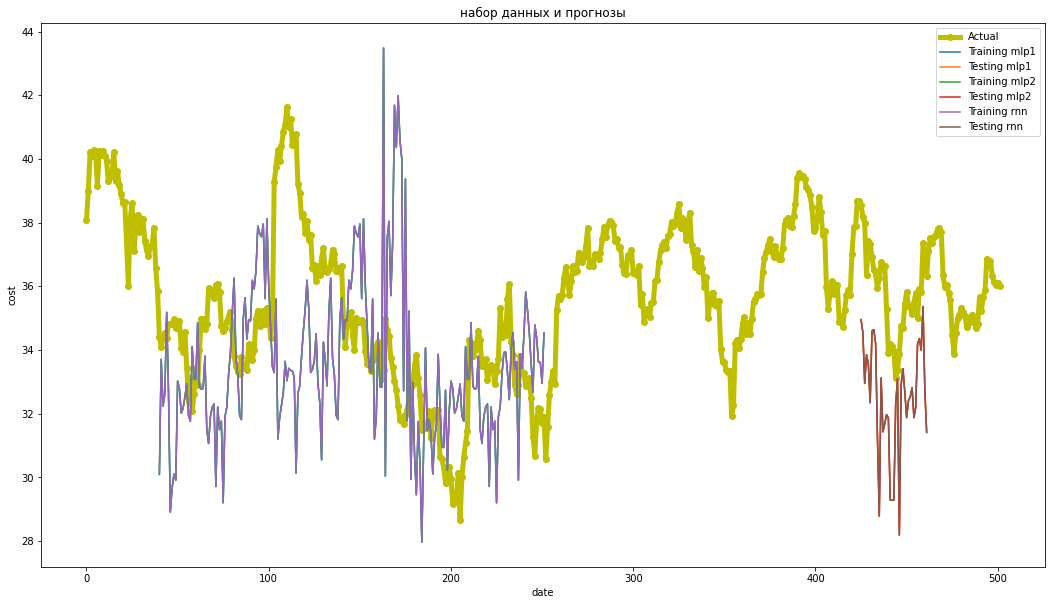

In [ ]:
# визуализируем полный набор данных и прогнозы моделей
plt.figure(figsize=(18, 10))
plt.plot([i for i in adj], marker='o', c='y', lw=5, label='Actual')

plt.plot(trainPredictPlot1.reshape(-1), label='Training mlp1')
plt.plot(testPredictPlot1.reshape(-1), label='Testing mlp1')

plt.plot(trainPredictPlot1.reshape(-1), label='Training mlp2')
plt.plot(testPredictPlot1.reshape(-1), label='Testing mlp2')

plt.plot(trainPredictPlot1.reshape(-1), label='Training rnn')
plt.plot(testPredictPlot1.reshape(-1), label='Testing rnn')

plt.legend(loc='best')
plt.xlabel("date")
plt.ylabel("cost")
plt.title("набор данных и прогнозы")
